In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip '/content/drive/MyDrive/data/real time.zip'

Archive:  /content/drive/MyDrive/data/real time.zip
   creating: real time/
   creating: real time/test/
   creating: real time/test/eating animal/
  inflating: real time/test/eating animal/16 (1).jpeg  
  inflating: real time/test/eating animal/16 (10).jpg  
  inflating: real time/test/eating animal/16 (100).jpg  
  inflating: real time/test/eating animal/16 (101).jpg  
  inflating: real time/test/eating animal/16 (102).jpg  
  inflating: real time/test/eating animal/16 (103).jpg  
  inflating: real time/test/eating animal/16 (104).jpg  
  inflating: real time/test/eating animal/16 (105).jpg  
  inflating: real time/test/eating animal/16 (106).jpg  
  inflating: real time/test/eating animal/16 (107).jpg  
  inflating: real time/test/eating animal/16 (108).jpg  
  inflating: real time/test/eating animal/16 (109).jpg  
  inflating: real time/test/eating animal/16 (11).jpg  
  inflating: real time/test/eating animal/16 (110).jpg  
  inflating: real time/test/eating animal/16 (111).jpg  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD
#from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [ ]:
import tensorflow as tf

In [ ]:
#tf.compat.v1.keras.backend

In [ ]:
#tf.config.list_physical_devices('GPU')

In [ ]:
train_path="/content/real time/train"
test_path="/content/real time/test"
class_names_train=os.listdir(train_path)
class_names_test=os.listdir(test_path)

In [ ]:
print(class_names_train)
print(class_names_test)

['sitting animal', 'eating animal', 'standing animal']
['sitting animal', 'eating animal', 'standing animal']


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [ ]:
data_dir = '../content/real time/train/'

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE=(48,48)
IMAGE_SHAPE=(48,48,3)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range=0.2,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size = IMAGE_SIZE,
    shuffle=True,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size = IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle= False,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 1588 images belonging to 3 classes.
Found 396 images belonging to 3 classes.


In [ ]:
#Implementation of Identity Block

In [ ]:
def identity_block(X, f, filters, stage, block):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [ ]:
#Implementation of Convolutional Block

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
#Implementation of ResNet-50
#In this Keras implementation of ResNet -50, we have not defined the fully connected layer in the network. We will see later why.

In [ ]:
def ResNet50(input_shape=(48, 48, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [ ]:
base_model = ResNet50(input_shape=(48, 48, 3))

In [ ]:
#Quick Concept about Transfer Learning
from keras import models



In [ ]:
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 128,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 3, activation='softmax', name='fc4',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [ ]:
model = Model(inputs=base_model.input, outputs=headModel)


In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 54, 54, 3)   0           ['input_5[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 24, 24, 64)   9472        ['zero_padding2d_4[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1[0][0]']            

In [ ]:
#Load the pre-trained weights of the model –

In [ ]:
#base_model.load_weights("/content/drive/MyDrive/friday/model/resnet50_weights_tf_dim_ordering_tf_kernels_notop (1).h5")
base_model.load_weights("/content/drive/MyDrive/Colab Notebooks/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [ ]:
# don't train existing weights
for layer in base_model.layers:
 layer.trainable =False

In [ ]:
for layer in model.layers[:-5]:
   layer.trainable = False


In [ ]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f193b219190> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f193def2550> False
<keras.layers.convolutional.Conv2D object at 0x7f193b18c650> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f193b1d7d50> False
<keras.layers.core.activation.Activation object at 0x7f193e285350> False
<keras.layers.pooling.MaxPooling2D object at 0x7f193b1d5250> False
<keras.layers.convolutional.Conv2D object at 0x7f193896ba10> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f193896bd50> False
<keras.layers.core.activation.Activation object at 0x7f193896f410> False
<keras.layers.convolutional.Conv2D object at 0x7f193913aed0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f193913f7d0> False
<keras.layers.core.activation.Activation object at 0x7f1939145750> False
<keras.layers.convolutional.Conv2D object at 0x7f193e467510> False
<keras

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d_1[0][0]']       
                                )                                                           

In [ ]:
#Early Stoping

In [ ]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

In [ ]:
mc = ModelCheckpoint('/content/real time.h5', monitor='val_accuracy', mode='max')


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
EPOCHS = 5
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples//BATCH_SIZE,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples//BATCH_SIZE,
    epochs = EPOCHS,
    verbose=1,
)

<ipython-input-106-69a7090cfd3e>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
49/49 [==============================] - 42s 822ms/step - loss: 0.0121 - accuracy: 0.9961 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 2/5
49/49 [==============================] - 38s 769ms/step - loss: 0.0239 - accuracy: 0.9949 - val_loss: 0.1290 - val_accuracy: 0.9609
Epoch 3/5
49/49 [==============================] - 37s 764ms/step - loss: 0.0187 - accuracy: 0.9955 - val_loss: 0.1945 - val_accuracy: 0.9505
Epoch 4/5
49/49 [==============================] - 37s 761ms/step - loss: 0.0125 - accuracy: 0.9974 - val_loss: 0.1738 - val_accuracy: 0.9583
Epoch 5/5
49/49 [==============================] - 36s 737ms/step - loss: 0.0095 - accuracy: 0.9968 - val_loss: 0.0280 - val_accuracy: 0.9896


In [ ]:
#Evaluating ResNet 50 model on test datasets
model.evaluate_generator(validation_generator)
#model.evaluate_generator(   )

<ipython-input-107-48cdfef968d3>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(validation_generator)


[0.022599000483751297, 0.9924242496490479]

In [ ]:
import matplotlib.pyplot as plt

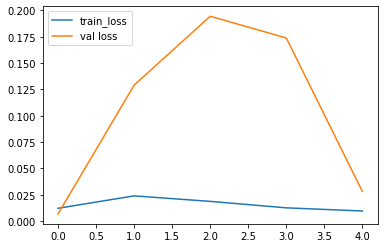

In [ ]:
# Plot the Loss

plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label ='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

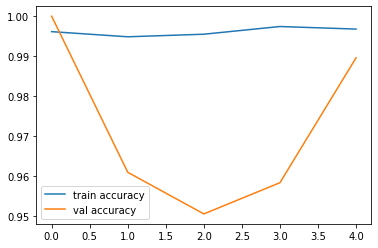

In [ ]:
# Plot the Accuracy
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['val_accuracy'], label ='val accuracy')
plt.legend()
plt.show()
# plt.savefig('valAccuracy')

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
batch_size = 32
num_of_test_samples = 600
predictions = model.predict_generator(validation_generator,  num_of_test_samples // batch_size)

y_pred = np.argmax(predictions, axis=1)

true_classes = validation_generator.classes

class_labels = list(validation_generator.class_indices.keys())

print(class_labels)

print(confusion_matrix(validation_generator.classes, y_pred))

report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

<ipython-input-111-141b779e1a8b>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(validation_generator,  num_of_test_samples // batch_size)


['eating animal', 'sitting animal', 'standing animal']
[[136   0   0]
 [  0  56   4]
 [  0   0 200]]
                 precision    recall  f1-score   support

  eating animal       1.00      1.00      1.00       136
 sitting animal       1.00      0.93      0.97        60
standing animal       0.98      1.00      0.99       200

       accuracy                           0.99       396
      macro avg       0.99      0.98      0.99       396
   weighted avg       0.99      0.99      0.99       396

